# Data cleaning example

Now we've gone over how to visualize and clean data, let's take a look at how we would use this in real life.

Our goal is to take a data set from an API, and use it for some analysis.  However, our API is a little flakey and the data sometimes isn't great, so we'll need to figure out what we need to correct

In [12]:
import requests
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline

In [3]:
def get_data(token):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-12-01').timestamp()))
        }
    )
    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [4]:
tokens = ['BTC', 'ETH', 'USDT', 'SOL', 'ADA', 'XRP', 'DOT', 'AVAX']

In [5]:
dfs = [
    (lambda x: x.assign(chain=np.where(x.token.isin(['ETH', 'AAVE', 'COMP']), np.full(x.shape[0], 'ETH'), x.token)))(get_data(token)) 
    for token in tokens
]

df = pd.concat(get_data(token) for token in tokens)
df['chain'] = np.where(df.token.isin(['ETH', 'AAVE', 'COMP']), np.full(df.shape[0], 'ETH'), df.token)
df.set_index('ts', inplace=True)

In [6]:
# do some chaos monkeying
df['close'] = df['close'].mask(np.random.random(df.shape[0]) < .05, other=np.nan)
df['close'] = df['close'].mask(np.random.random(df.shape[0]) < .01, other=df['close'] * 100)
df['token'] = df['token'].mask(np.random.random(df.shape[0]) < .05, other='<a>' + df['token'] + '</a>')
df = df.append(df.sample(frac=0.1)).sample(frac=1)

First, let's check our time series

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5513 entries, 2021-12-11 19:00:00 to 2021-12-29 04:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       5513 non-null   float64
 1   high       5513 non-null   float64
 2   low        5513 non-null   float64
 3   close      5236 non-null   float64
 4   volume     5513 non-null   float64
 5   volumeUSD  5513 non-null   float64
 6   token      5513 non-null   object 
 7   chain      5513 non-null   object 
dtypes: float64(6), object(2)
memory usage: 387.6+ KB


we can see that we have 2264, total entries, but close has a bunch of nulls

In [8]:
df['token'].value_counts()

DOT            763
AVAX           759
ADA            748
USDT           746
SOL            745
ETH            745
BTC            739
<a>BTC</a>      46
<a>SOL</a>      46
<a>AVAX</a>     40
<a>ETH</a>      39
<a>USDT</a>     39
<a>ADA</a>      31
<a>DOT</a>      27
Name: token, dtype: int64

we also have some badly formatted token names (maybe we pulled from html)

In [9]:
df.duplicated().sum()

501

we also have some duplicated rows it looks like

<AxesSubplot:xlabel='ts'>

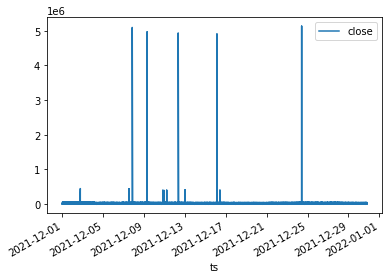

In [10]:
df[['token', 'close']].plot()

this plot doens't make sense because we have a long table.  Let's plot by token

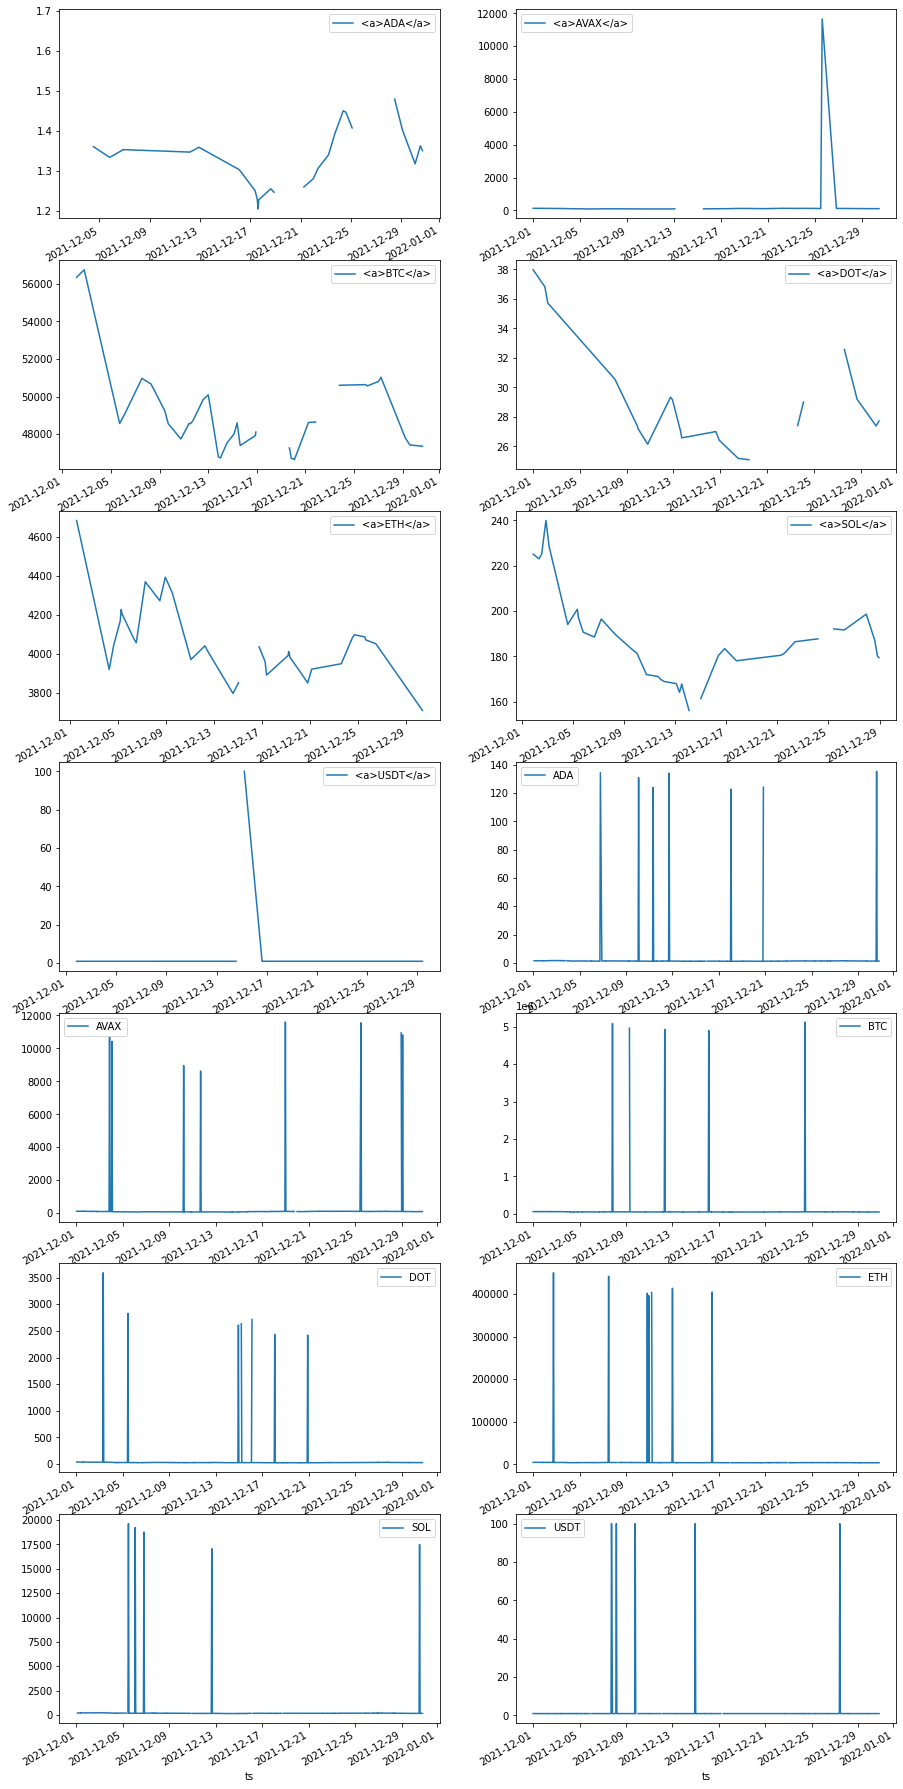

In [13]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1


we definitely see some missing data from this plot, but also we definitely have some outliers in our data

okay so what do we do?  let's get a plan of attack:
1. Let's remove the duplicated rows
2. Let's format the names for the tokens so we don't have the ones with tags
3. Let's use a heuristic for missing close price as average of high + low of they day

After this, we can take a look at our chart and see how we want to deal with the outliers


1. drop duplicates

In [14]:
df = df.drop_duplicates()

2. let's format the token names

In [15]:
df.loc[df['token'].str.contains('<a>'), 'token'] = df.loc[df['token'].str.contains('<a>'), 'token'].str.extract('<a>(.|\n)*?<\/a>')


3. use the heuristic for missing close prices as verage of high + low of the day

In [16]:
df.loc[df['close'].isnull(), 'close'] = 0.5 * (df.loc[df['close'].isnull(), 'high'] + df.loc[df['close'].isnull(), 'low'])

Let's plot the same chart again

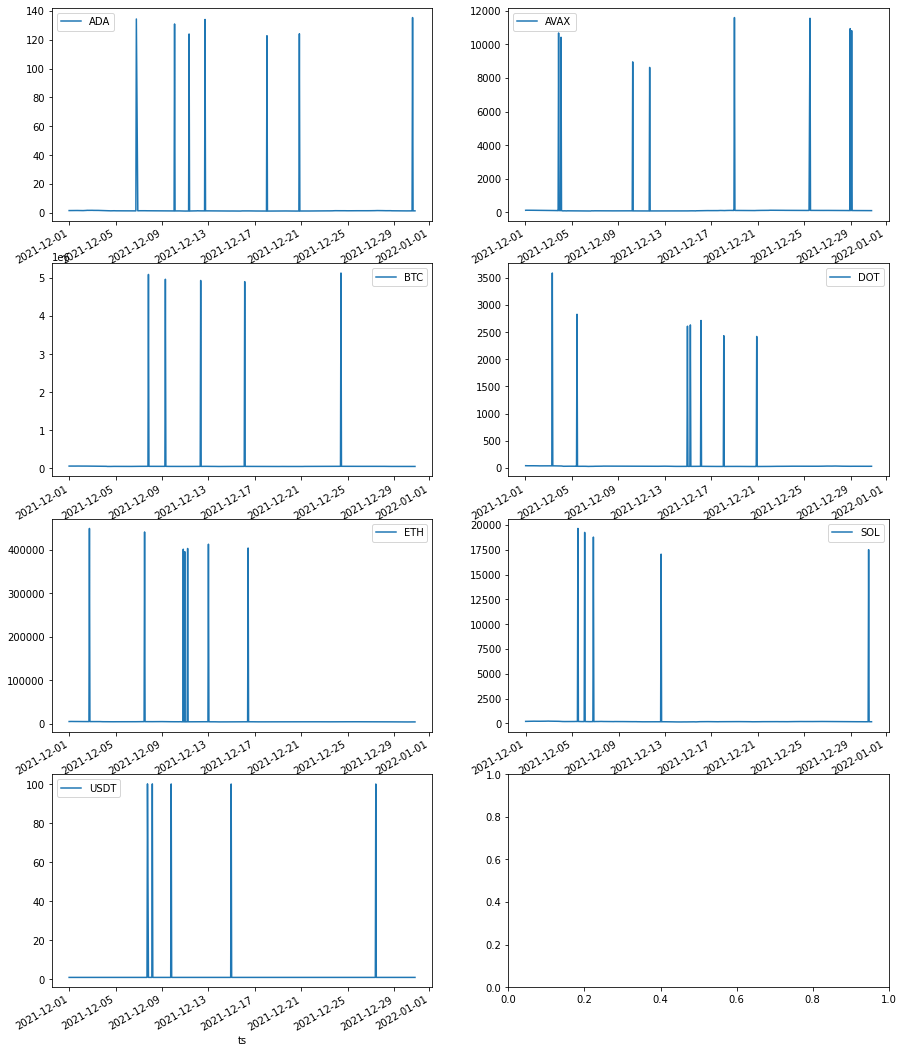

In [17]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1


So we now have good names, no duplicates and no missing values as we can see from the chart, however we still have these massive outliers.  Let's see how to deal with these.

Let's come up with a heuristic to define an outlier, as something where the close price is greater than 2x higher or lower than the open price (given this is hourly data, we shouldn't expect it to change that much)

In [18]:
df.loc[df.close / df.open >= 2]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-14 23:00:00,1.0005,1.0005,1.0003,100.05,4.247905e+06,4.249822e+06,USDT,USDT
2021-12-02 18:00:00,4485.3800,4511.4200,4477.9700,449625.00,1.054044e+04,4.739612e+07,ETH,ETH
2021-12-12 17:00:00,1.3314,1.3427,1.3254,134.04,1.608369e+06,2.144700e+06,ADA,ADA
2021-12-16 10:00:00,4030.7200,4047.4300,4028.6800,404522.00,2.322619e+03,9.380745e+06,ETH,ETH
2021-12-13 00:00:00,4156.8400,4172.0000,4127.4000,413292.00,5.090836e+03,2.113033e+07,ETH,ETH
2021-12-04 02:00:00,102.7200,104.4800,101.5000,10421.00,7.056393e+04,7.263969e+06,AVAX,AVAX
2021-12-19 00:00:00,115.2800,116.3700,115.0100,11594.00,7.426636e+04,8.605418e+06,AVAX,AVAX
2021-12-10 23:00:00,3996.1700,4008.7700,3953.7700,396132.00,8.379371e+03,3.335654e+07,ETH,ETH
2021-12-20 20:00:00,1.2238,1.2430,1.2233,124.10,3.264627e+06,4.029677e+06,ADA,ADA


this heuristic looks okay - let's use the missing value heuristic to fill these in:

In [19]:
df.loc[df.close / df.open >= 2, 'close'] = 0.5 * (df.loc[df.close / df.open >= 2, 'high'] + df.loc[df.close / df.open >= 2, 'low'])


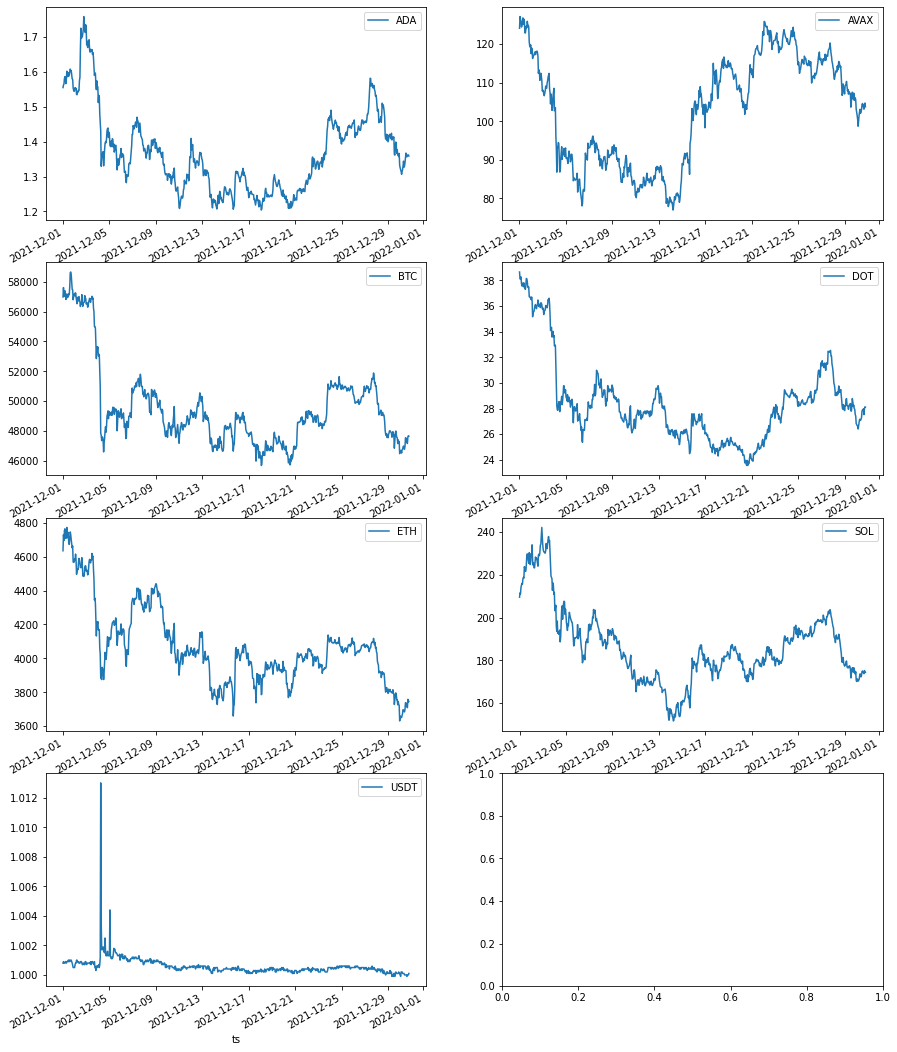

In [20]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1
